# Naive Bayes Classifier Implementation from scratch

In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [4]:
#To avoid divide by zero error, replacing o variance with epsilon
epsilon = 1e-6

In [5]:
class NBC:
    """
    Naive Bayes Classifier 
    """
    
    def __init__(self, feature_types, num_classes):
        """
        Constructor declaration
        """
        if feature_types:
            assert all([ft == 'r' for ft in feature_types]) #Feature types can only be real - 'r' 
            assert num_classes >= 2 #Number of classes should be greater than 2
    
    def fit(self, X, y):
        """
        Estimates parameters of NBC
        i.e. mean, variance and priors
        """
        n_samples, n_features = X.shape #no of samples and features
        self._classes = np.unique(y) #Unique elements (classes)
        n_classes = len(self._classes) #No of classes
        
        # initialize mean, variance, and prior for each class
        self._mean = np.zeros((n_classes, n_features), dtype=float)
        self._var = np.zeros((n_classes, n_features), dtype=float)
        self._priors = np.zeros(n_classes, dtype=float)
        
        # calculate mean, variance, and prior for each class
        for idx, c in enumerate(self._classes):
            X_c = X[y == c] #samples of class a particular class c
            self._mean[idx, :] = X_c.mean(axis=0) #mean for class c
            self._var[idx, :] = X_c.var(axis=0)   #variance for class c
            self._priors[idx] = X_c.shape[0] / float(n_samples) #Pr(yc) frequency of class c

  
    def predict(self, X):
        """
        Predict class for all samples in X 
        and save in y_pred
        """
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    
    def _predict(self, x):
        """
        Predict class for one sample in x
        """
        posteriors = [] # Pr(y|X)

        # calculate posterior probability for each class
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            posterior = np.sum((self._logpdf(idx, x)))
            posterior = prior + posterior
            posteriors.append(posterior)

        # return class with highest posterior probability
        return self._classes[np.argmax(posteriors)]

    def _logpdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        var[var < epsilon] = epsilon #check if variance=0, and replace with epsilon
        numerator = -(x - mean) ** 2 / (2 * var)
        denominator = np.sqrt(2 * np.pi * var)
        return numerator - np.log(denominator)

In [6]:
#Importing IRIS dataset

iris = load_iris()
X, y = iris['data'], iris['target']

In [7]:
#N = no of data points, D = size of feature vector
#Shuffle and divide data in training and testing set

N, D = X.shape
Ntrain = int(0.8 * N) #Taking 80% data for training and rest for testing
shuffler = np.random.permutation(N)
Xtrain = X[shuffler[:Ntrain]]
ytrain = y[shuffler[:Ntrain]]
Xtest = X[shuffler[Ntrain:]]
ytest = y[shuffler[Ntrain:]]

print(Xtrain.shape)
print(Xtest.shape)

(120, 4)
(30, 4)


In [8]:
#Testing NBC implementation

nbc = NBC(feature_types=['r','r','r'], num_classes=4)
nbc.fit(Xtrain, ytrain)
yhat = nbc.predict(Xtest)
test_accuracy = np.mean(yhat == ytest)

print(test_accuracy)

0.9


C is inverse of regularization strength. Hence let 𝜆 = 0.1, then C = 1/0.1 = 10

In [9]:
def error_compute(X, y, perm):
    
    N, D = X.shape
    Ntrain = int(0.8 * N)
    avg_errors = {'lr': [], 'nbc': []} #error dictionary 
    
    training_sizes = [int(k*Ntrain) for k in np.arange(0.1, 1.1, 0.1)] 
    
    #train 10 classifiers, kth classifier is trained using (10k)% of data 
    for ntrain in training_sizes:
        error = {'lr': 0, 'nbc': 0}

        for i in range(perm):
            shuffler = np.random.permutation(N) 
            Xtrain = X[shuffler[:ntrain]]
            ytrain = y[shuffler[:ntrain]]
            Xtest = X[shuffler[ntrain:]]
            ytest = y[shuffler[ntrain:]]
            
            # Logistic Regression using sklearn
            logreg = LogisticRegression(C=10) 
            logreg.fit(Xtrain, ytrain)
            error['lr'] += 1 - logreg.score(Xtest, ytest)
            
            # Naive Bayes Classifier using defined class NBC()
            nbc = NBC(feature_types=['r','r','r'], num_classes=4)
            nbc.fit(Xtrain, ytrain)
            yhat = nbc.predict(Xtest)
            test_accuracy = np.mean(yhat == ytest)
            error['nbc'] += 1 - test_accuracy

        # Average errors of Logistic Regression & Naive Bayes after 'perm' times run for kth classifier
        avg_errors['lr'].append(error['lr']/perm)
        avg_errors['nbc'].append(error['nbc']/perm)
        
        
    return training_sizes, avg_errors
    
    

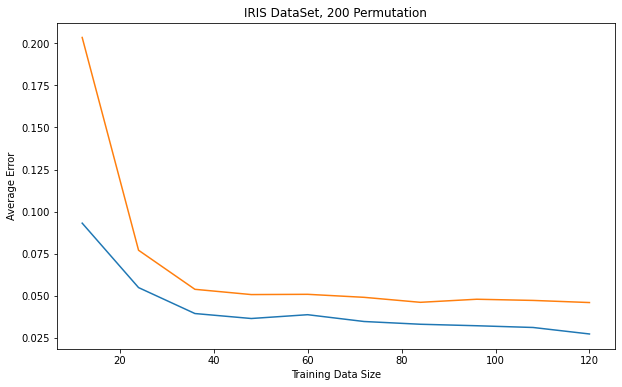

In [10]:
#200 permutations 

training_size, errors = error_compute(X, y, perm = 200)

#Plot of average error for NBC and Logistic Regression
plt.figure(figsize=(10,6))
plt.title('IRIS DataSet, 200 Permutation')
plt.xlabel('Training Data Size')
plt.ylabel('Average Error')
plt.plot(training_size, errors['lr'], label='Linear Regression')
plt.plot(training_size, errors['nbc'], label='Naive Bayes')

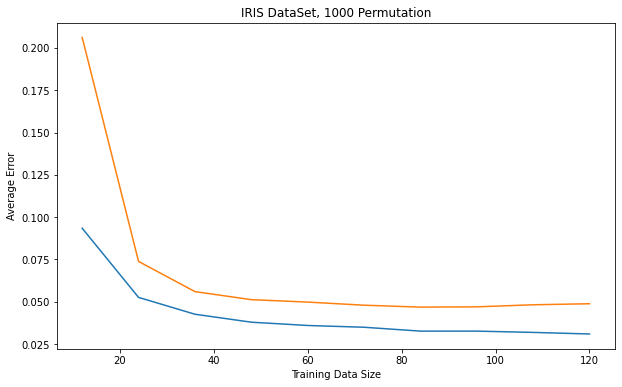

In [11]:
#1000 permutations

training_size, errors = error_compute(X, y, perm = 1000)

#Plot of average error for NBC and Logistic Regression
plt.figure(figsize=(10,6))
plt.title('IRIS DataSet, 1000 Permutation')
plt.xlabel('Training Data Size')
plt.ylabel('Average Error')
plt.plot(training_size, errors['lr'], label='Linear Regression')
plt.plot(training_size, errors['nbc'], label='Naive Bayes')
